In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from numpy import asarray, savetxt
from datetime import datetime, date
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset

In [10]:
batch_size = 64
validation_split = 0.95
epochs = 30
lr = 0.001
dataset_size = 1000

In [3]:
available_classes = [0, 1] #plane, car
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

m = torchvision.datasets.CIFAR10(root='./data', train=True,
                                     download=True, transform=transform)

targets = np.array(m.targets)
class_0 = np.nonzero(targets == 0)
class_1 = np.nonzero(targets == 1)
a = m.data[class_0[0]]
b = m.data[class_1[0]]
e = np.concatenate((a,b), axis=0)
m.data = e

a = targets[class_0[0]]
b = targets[class_1[0]]
e = np.concatenate((a,b), axis=0).tolist()
m.targets = e

X_train, X_test, _, _ = train_test_split(
    range(len(m)),
    m.targets,
    stratify=m.targets,
    test_size=validation_split,
    random_state=8
)

train_split = Subset(m, X_train)
test_split = Subset(m, X_test)

train_data_loader = DataLoader(train_split, batch_size=batch_size,
                                                   shuffle=True)
test_data_loader = DataLoader(test_split, batch_size=batch_size,
                                                   shuffle=True)

Files already downloaded and verified


In [4]:
len(X_train)

100

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding='same')
        self.conv2 = nn.Conv2d(32, 32, 3, padding='same')
        self.mp = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(32, 64, 3, padding='same')
        self.conv4 = nn.Conv2d(64, 64, 3, padding='same')
        self.conv5 = nn.Conv2d(64, 128, 3, padding='same')
        self.conv6 = nn.Conv2d(128, 128, 3, padding='same')
        self.fc1 = nn.Linear(2048, 128)
        self.fc2 = nn.Linear(128, 2)
        

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.mp(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.mp(x)
        
        x = self.conv5(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = F.relu(x)
        x = self.mp(x)
       
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [6]:
def plot_losses(metrics):
    x = list(range(1, epochs+1))
    plt.plot(x, metrics['loss'], '-b', label='loss')
    
    plt.xlabel("epochs")
    plt.legend(loc='upper left')
    plt.title('Loss')
    plt.savefig("loss.png") 
    plt.show()
    
    plt.plot(x, metrics['acc'], '-r', label='acc')
    plt.xlabel("epochs")
    plt.legend(loc='upper left')
    plt.title('Acc')
    plt.savefig("acc.png") 
    plt.show()

In [7]:
def accuracy_with_validation_set(valid_loader):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    net = Net().to(device)
    net.load_state_dict(torch.load(f'./cifar_net_{epochs}.pth'))
    net.eval()

    classes = {0: 'plane', 1: 'car'}

    # prepare to count predictions for each class
    correct_pred = {classname: 0 for _, classname in classes.items()}
    total_pred = {classname: 0 for _, classname in classes.items()}

    # again no gradients needed
    with torch.no_grad():
        for inputs, labels in valid_loader:
            images, labels = inputs.to(device), labels.to(device)
            outputs = net(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                label = label.item()
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

    total_count = 0
    total_correct = 0
    for classname, correct_count in correct_pred.items():
        total_count += total_pred[classname]
        total_correct += correct_count
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    
    accuracy = 100 * float(total_correct) /  total_count
    print(f'Total accuracy is {accuracy:.1f} %')

In [8]:
def main(train_data_loader):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'Device being used is {device}')

    start = datetime.combine(date.today(), datetime.now().time())
    print(f'Starting time is: {start}')

    metrics = {"loss": [], "acc": []}
    
    net = Net().to(device)
    if device == 'cuda':
        net = torch.nn.DataParallel(net)
        cudnn.benchmark = True

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr,
                          momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 30])

    print('-----------')
    for epoch in range(epochs):
        net.train()
        running_loss, correct, total, batch_idx = 0, 0, 0, 0
        for batch_idx, (inputs, labels) in enumerate(train_data_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, predictions = outputs.max(1)
            running_loss += loss.item()
            total += labels.size(0)
            correct += predictions.eq(labels).sum().item()

            if batch_idx % 10 == 0:
                print(
                    f'[Epoch: {epoch + 1} / {epochs} | {batch_idx + 1} / {len(train_data_loader) + 1}] Loss: {running_loss / (batch_idx + 1):.3f} | Acc: {100. * correct / total:.3f} ({correct}/{total})')

        metrics['loss'].append((running_loss / (batch_idx + 1)))
        metrics['acc'].append(100. * correct / total)
        scheduler.step()

    end = datetime.combine(date.today(), datetime.now().time())
    duration = end - start
    print('')
    print('')
    print(f'Finished Training in: {duration}')
    print('-----------')

    torch.save(net.state_dict(), f'./cifar_net_{epochs}.pth')

    savetxt('data-loss.csv', asarray(metrics['loss']), delimiter=',')
    savetxt('data-acc.csv', asarray(metrics['acc']), delimiter=',')
    
    return metrics

Device being used is cuda:0
Starting time is: 2022-02-22 20:42:27.673557
-----------
[Epoch: 1 / 30 | 1 / 3] Loss: 0.692 | Acc: 54.688 (35/64)
[Epoch: 2 / 30 | 1 / 3] Loss: 0.691 | Acc: 56.250 (36/64)
[Epoch: 3 / 30 | 1 / 3] Loss: 0.694 | Acc: 48.438 (31/64)
[Epoch: 4 / 30 | 1 / 3] Loss: 0.693 | Acc: 51.562 (33/64)
[Epoch: 5 / 30 | 1 / 3] Loss: 0.694 | Acc: 48.438 (31/64)
[Epoch: 6 / 30 | 1 / 3] Loss: 0.692 | Acc: 53.125 (34/64)
[Epoch: 7 / 30 | 1 / 3] Loss: 0.692 | Acc: 53.125 (34/64)
[Epoch: 8 / 30 | 1 / 3] Loss: 0.692 | Acc: 53.125 (34/64)
[Epoch: 9 / 30 | 1 / 3] Loss: 0.693 | Acc: 50.000 (32/64)
[Epoch: 10 / 30 | 1 / 3] Loss: 0.693 | Acc: 48.438 (31/64)
[Epoch: 11 / 30 | 1 / 3] Loss: 0.693 | Acc: 48.438 (31/64)
[Epoch: 12 / 30 | 1 / 3] Loss: 0.694 | Acc: 46.875 (30/64)
[Epoch: 13 / 30 | 1 / 3] Loss: 0.694 | Acc: 45.312 (29/64)
[Epoch: 14 / 30 | 1 / 3] Loss: 0.695 | Acc: 42.188 (27/64)
[Epoch: 15 / 30 | 1 / 3] Loss: 0.694 | Acc: 46.875 (30/64)
[Epoch: 16 / 30 | 1 / 3] Loss: 0.692 | 

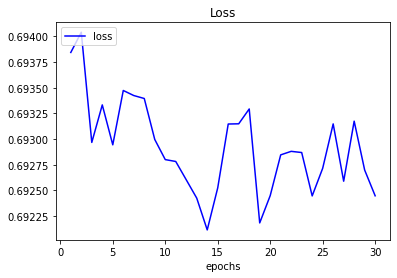

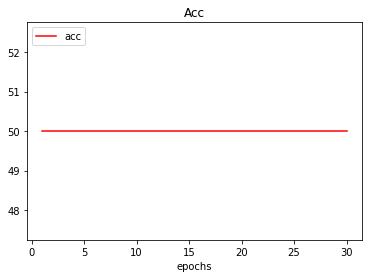

Accuracy for class: plane is 100.0 %
Accuracy for class: car   is 0.0 %
Total accuracy is 50.0 %


In [11]:
metrics = main(train_data_loader)
plot_losses(metrics)
accuracy_with_validation_set(test_data_loader)